In [2]:
library(mclust)
library(flexmix)
library(ggplot2)
suppressPackageStartupMessages(library(dendextend))
library(caret)
library(mvtnorm)
library(rsvd)

# Load and Inspect the Data

In [3]:
data(banknote)

In [4]:
head(banknote)

Status,Length,Left,Right,Bottom,Top,Diagonal
genuine,214.8,131.0,131.1,9.0,9.7,141.0
genuine,214.6,129.7,129.7,8.1,9.5,141.7
genuine,214.8,129.7,129.7,8.7,9.6,142.2
genuine,214.8,129.7,129.6,7.5,10.4,142.0
genuine,215.0,129.6,129.7,10.4,7.7,141.8
genuine,215.7,130.8,130.5,9.0,10.1,141.4


In [5]:
banknote[sample.int(nrow(banknote), 5), ]

,Status,Length,Left,Right,Bottom,Top,Diagonal
108,counterfeit,214.8,130.1,130.4,9.8,11.5,139.9
36,genuine,214.6,130.2,130.2,9.4,9.7,141.8
100,genuine,214.7,130.0,129.4,7.8,10.0,141.2
4,genuine,214.8,129.7,129.6,7.5,10.4,142.0
7,genuine,215.5,129.5,129.7,7.9,9.6,141.6


In [6]:
summary(banknote)

         Status        Length           Left           Right      
 counterfeit:100   Min.   :213.8   Min.   :129.0   Min.   :129.0  
 genuine    :100   1st Qu.:214.6   1st Qu.:129.9   1st Qu.:129.7  
                   Median :214.9   Median :130.2   Median :130.0  
                   Mean   :214.9   Mean   :130.1   Mean   :130.0  
                   3rd Qu.:215.1   3rd Qu.:130.4   3rd Qu.:130.2  
                   Max.   :216.3   Max.   :131.0   Max.   :131.1  
     Bottom            Top           Diagonal    
 Min.   : 7.200   Min.   : 7.70   Min.   :137.8  
 1st Qu.: 8.200   1st Qu.:10.10   1st Qu.:139.5  
 Median : 9.100   Median :10.60   Median :140.4  
 Mean   : 9.418   Mean   :10.65   Mean   :140.5  
 3rd Qu.:10.600   3rd Qu.:11.20   3rd Qu.:141.5  
 Max.   :12.700   Max.   :12.30   Max.   :142.4  

Apply PCA with two Components to the data to obtain a two-dimensional representation of the Swiss banknotes.

In [7]:
banknote_pca <- prcomp(banknote[,2:7], scale. = FALSE)

In [8]:
# first two for 2D
pcs_banknote <- banknote_pca$x[,1:2]

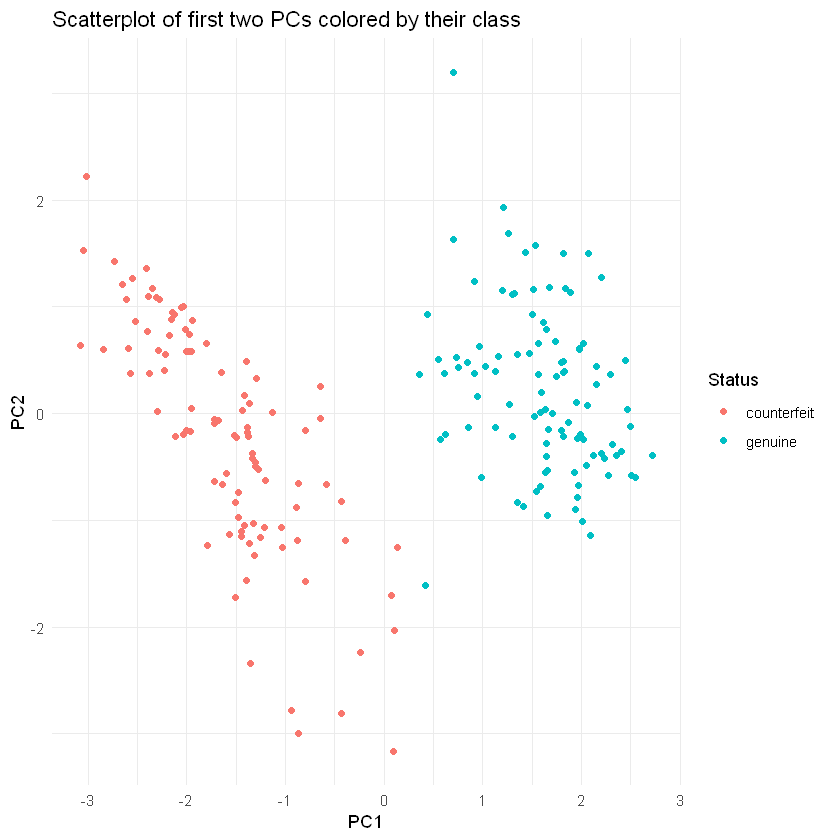

In [9]:
# Plot the pcs in 2D
plot_data <- data.frame('PC1' = pcs_banknote[,1], 'PC2' = pcs_banknote[,2] , 'Status' = banknote$Status)
ggplot(plot_data, aes(PC1, PC2, color=Status)) + 
geom_point() +
theme_minimal() +
labs(title = 'Scatterplot of first two PCs colored by their class')                                

We can see that the dataset is well seperated in its first two principal componenents. Hence, it should be easy to cluster them.

# Agglomerative Hierarchical Clustering

Since Clustering is based on similarity measured e.g. by distance, we introduce functions to compute similarity of binary vectors.

In [10]:
# functions for binary distances
matching_coefficient <- function(x, y){
    stopifnot(length(x) == length(y))

    sum(x == y) / length(x)
}

similarity_coefficient <- function(x, y){
    stopifnot(length(x) == length(y))

    a11 <- sum(x * y)
    a10 <- sum(x == 1 & y == 0)
    a01 <- sum(x == 0 & y == 1)
    a11 / (a11 + a10 + a01)
}

general_similarity_measurement <- function(x, y, alpha = 1, beta=1) {
    a11 <- sum(x * y)
    a00 <- sum(x + y == 0)
    a10 <- sum(x == 1 & y == 0)
    a01 <- sum(x == 0 & y == 1)

    (a11 + alpha * a00) / (a11 + alpha * a00 + beta*(a10 + a01))
}

We test the binary measurements with two vectors where each case of match for a single digit is exactly contained once, i.e., for two vectors at position i the following cases can occur: both 0 (a00), both 1(a11), first 0 and second 1 (a01) or the other way around (a10).

In [11]:
x <- c(1, 0, 0, 1)
y <- c(1, 1, 0, 0)

# distances
matching_coefficient(x, y)
similarity_coefficient(x,y)
general_similarity_measurement(x,y)

[1] 0.5

[1] 0.3333333

[1] 0.5

Now, for the hierarchical clustering, we compute the euclidian distance on the first two principal components.

In [12]:
# compute the distance matrix
dist_banknote <- dist(pcs_banknote)

In [13]:
cl_single <- hclust(dist_banknote, method = 'single')
cl_complete <- hclust(dist_banknote, method = 'complete')
cl_mean <- hclust(dist_banknote, method = 'average')
cl_ward <- hclust(dist_banknote, method = 'ward.D2')

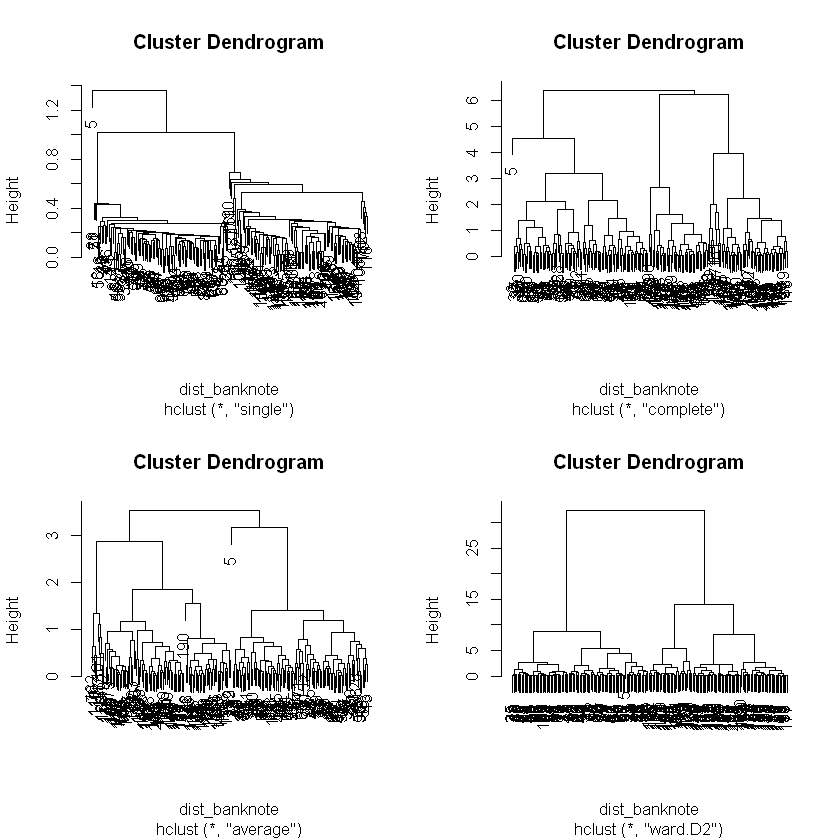

In [14]:
par(mfrow = c(2,2))
plot(cl_single)
plot(cl_complete)
plot(cl_mean)
plot(cl_ward)

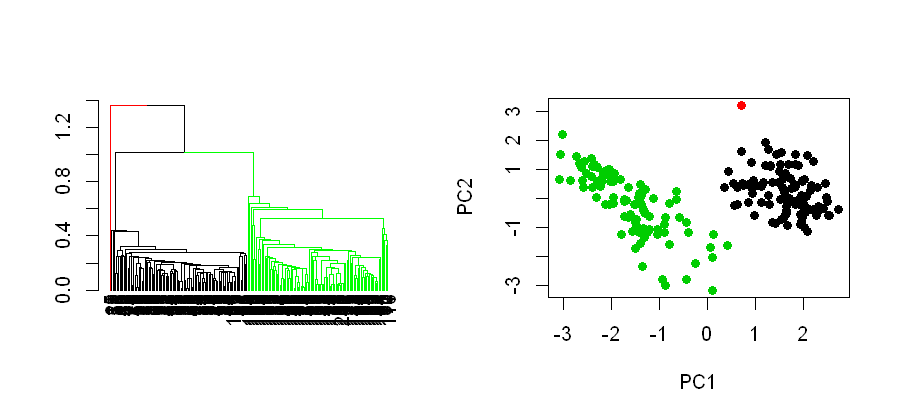

In [15]:
# Now color the respective cluster
par(mfrow = c(1,2))
options(repr.plot.width = 7.5, repr.plot.height = 3.5)
plot(color_branches(as.dendrogram(cl_single), k = 3, col= c('red','black',  'green')))
plot(pcs_banknote, col = cutree(cl_single, k=3), pch = 16)

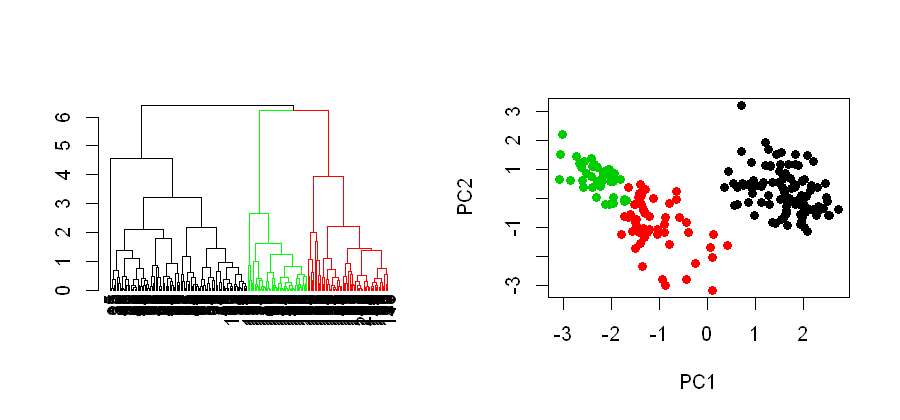

In [16]:
par(mfrow = c(1,2))
options(repr.plot.width = 7.5, repr.plot.height = 3.5)
plot(color_branches(as.dendrogram(cl_complete), k = 3, col= c('black', 'green','red')))
plot(pcs_banknote, col = cutree(cl_complete, k=3), pch = 16)

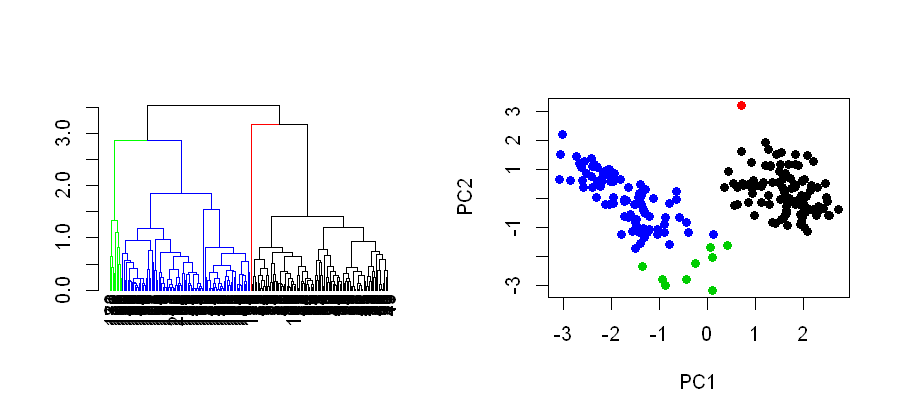

In [17]:
par(mfrow = c(1,2))
options(repr.plot.width = 7.5, repr.plot.height = 3.5)
plot(color_branches(as.dendrogram(cl_mean), k = 4, col=c('green', 'blue', 'red', 'black')))
plot(pcs_banknote, col = cutree(cl_mean, k=4), pch = 16)

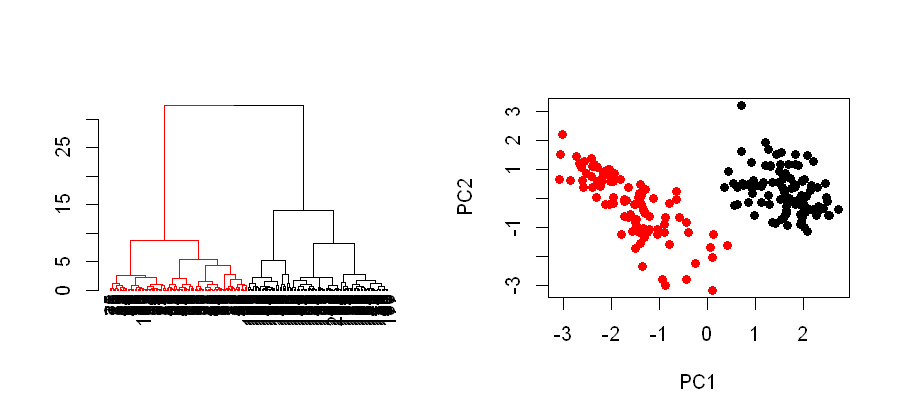

In [18]:
par(mfrow = c(1,2))
options(repr.plot.width = 7.5, repr.plot.height = 3.5)
plot(color_branches(as.dendrogram(cl_ward), k = 2, col = c('red', 'black')))
plot(pcs_banknote, col = cutree(cl_ward, k=2), pch = 16)

In conclusion, we observe that the clustering with ward's method works best for our data.

# K-Means

In the following, we apply K-Means clustering to the Swiss banknote dataset. First on the full data and then on the first two principal components only.

In [19]:
set.seed(2022)
(kmeans_swiss <- kmeans(banknote[, -1], centers = 2, iter.max = 100, nstart = 1, algorithm = "Lloyd"))

K-means clustering with 2 clusters of sizes 100, 100

Cluster means:
   Length    Left   Right Bottom    Top Diagonal
1 214.823 130.300 130.193 10.530 11.133  139.450
2 214.969 129.943 129.720  8.305 10.168  141.517

Clustering vector:
  [1] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [75] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1
[112] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[186] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

Within cluster sum of squares by cluster:
[1] 225.2233 142.8852
 (between_SS / total_SS =  58.8 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

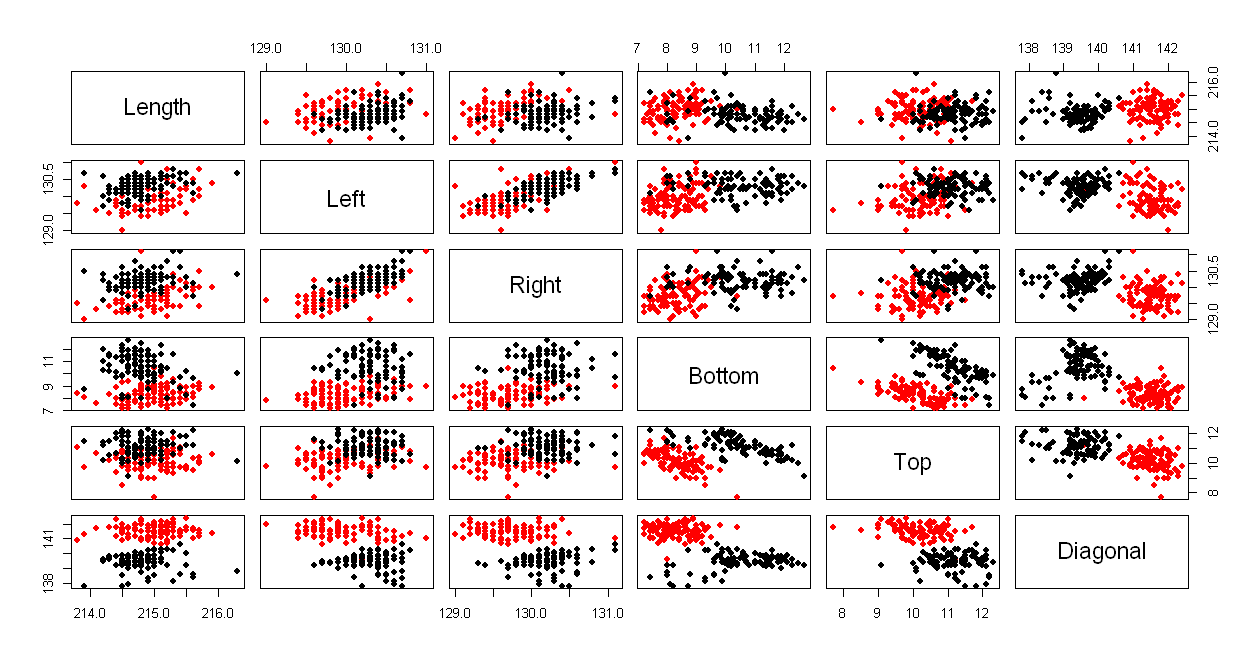

In [20]:
options(repr.plot.width = 10.5, repr.plot.height = 5.5)
pairs(banknote[, -1], col=kmeans_swiss$cluster, pch=16)

In [21]:
# Accuracy
sum(diag(table(kmeans_swiss$cluster, banknote[, 1]))) / length(banknote[,1])

[1] 1

In [22]:
confusionMatrix(as.factor(ifelse(kmeans_swiss$cluster == 1, 'counterfeit', 'genuine')), banknote[,1])

Confusion Matrix and Statistics

             Reference
Prediction    counterfeit genuine
  counterfeit         100       0
  genuine               0     100
                                     
               Accuracy : 1          
                 95% CI : (0.9817, 1)
    No Information Rate : 0.5        
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0        
            Specificity : 1.0        
         Pos Pred Value : 1.0        
         Neg Pred Value : 1.0        
             Prevalence : 0.5        
         Detection Rate : 0.5        
   Detection Prevalence : 0.5        
      Balanced Accuracy : 1.0        
                                     
       'Positive' Class : counterfeit
                                     

In [23]:
# Repeat for only first two principal diagnoses
set.seed(2022)
(kmeans_swiss <- kmeans(pcs_banknote, centers = 2, iter.max = 100, nstart = 100, algorithm = "Lloyd"))

K-means clustering with 2 clusters of sizes 100, 100

Cluster means:
        PC1        PC2
1 -1.606522 -0.2242454
2  1.606522  0.2242454

Clustering vector:
  [1] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [75] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1
[112] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[186] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

Within cluster sum of squares by cluster:
[1] 166.71184  90.29782
 (between_SS / total_SS =  67.2 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

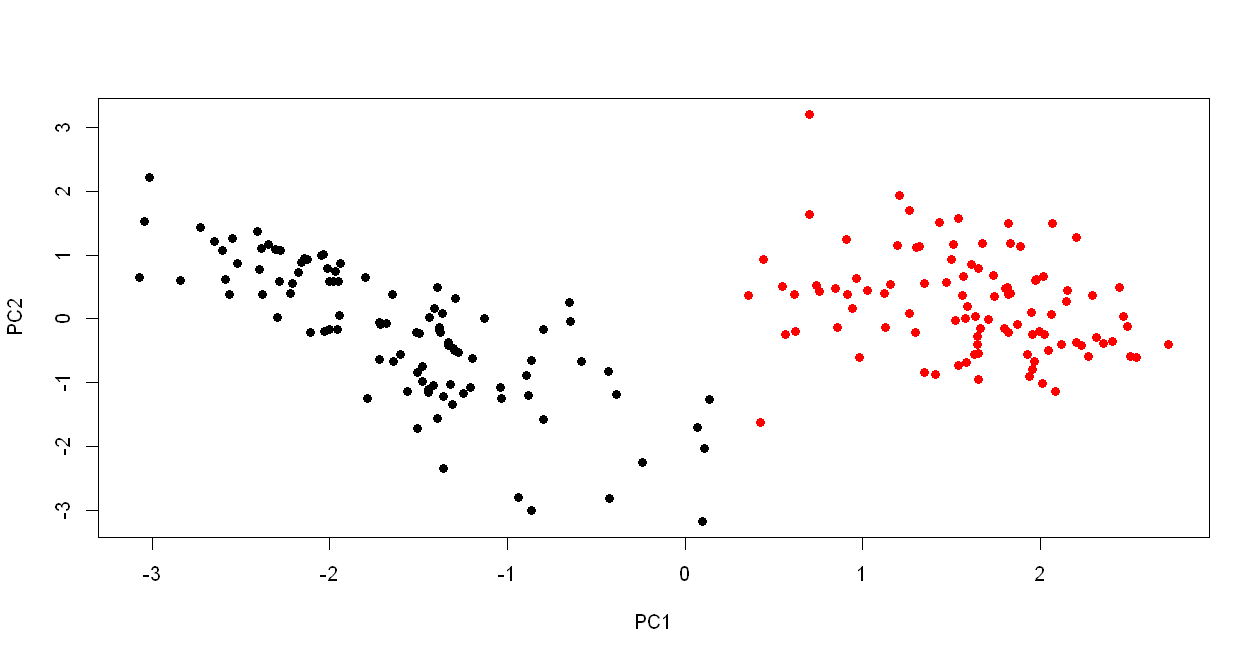

In [24]:
plot(pcs_banknote, col= as.factor(kmeans_swiss$cluster), pch=16)

In [25]:
confusionMatrix(as.factor(ifelse(kmeans_swiss$cluster == 1, 'counterfeit', 'genuine')), banknote[,1])

Confusion Matrix and Statistics

             Reference
Prediction    counterfeit genuine
  counterfeit         100       0
  genuine               0     100
                                     
               Accuracy : 1          
                 95% CI : (0.9817, 1)
    No Information Rate : 0.5        
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0        
            Specificity : 1.0        
         Pos Pred Value : 1.0        
         Neg Pred Value : 1.0        
             Prevalence : 0.5        
         Detection Rate : 0.5        
   Detection Prevalence : 0.5        
      Balanced Accuracy : 1.0        
                                     
       'Positive' Class : counterfeit
                                     

For this dataset, K-Means works well on the whole data as well as the first two principal components, since it works well if the cluster are spherical which is the case for the Swiss banknote dataset.

# Mixture Models and the Expectation Maximization Algorithm

First we will see how K-Means fails on the IRIS dataset, because the three clusters are not clearly distinguishable. Since the EM algorithm leverages an assumption about the data distribution it is able to better distinguish the clusters in IRIS. We assume the specieses to be normal distributed for the standart EM algorithm.

In [26]:
data(iris)

In [27]:
set.seed(33)
kmeans_iris <- kmeans(iris[, 1:4], centers = 3, iter.max = 10, nstart = 100)
em_iris <- Mclust(iris[, 1:4], G=3)

In [28]:
(kmeans_ct <- table(kmeans_iris$cluster, iris$Species))

   
    setosa versicolor virginica
  1     50          0         0
  2      0         48        14
  3      0          2        36

In [29]:
# Accuracy of kmeans on Iris
sum(diag(kmeans_ct)) / length(iris$Species)

[1] 0.8933333

In [30]:
(em_ct <- table(em_iris$classification, iris$Species))

   
    setosa versicolor virginica
  1     50          0         0
  2      0         45         0
  3      0          5        50

In [31]:
sum(diag(em_ct)) / length(iris$Species) # Much better than Kmeans

[1] 0.9666667

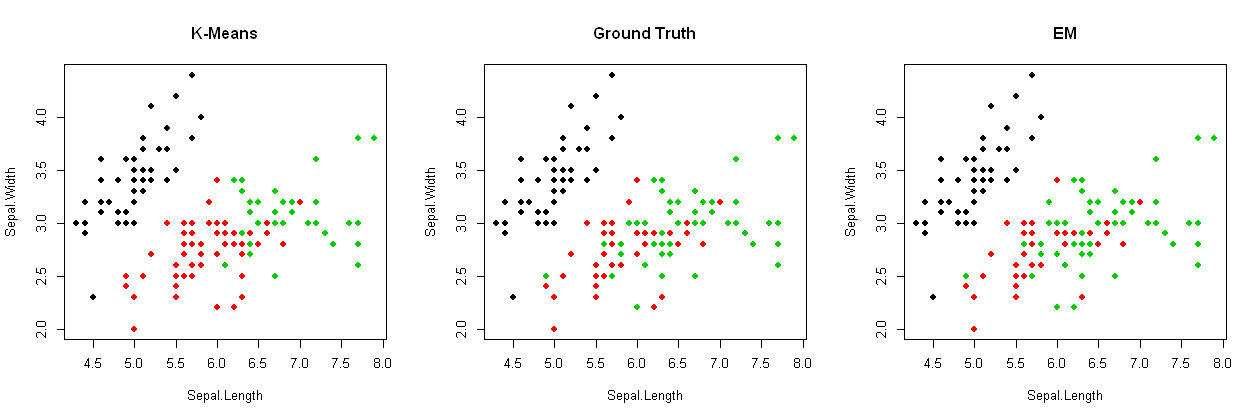

In [32]:
# visual comparison
par(mfrow = c(1,3))
options(repr.plot.width = 10.5, repr.plot.height = 3.5)
plot(iris[, 1:2], col=kmeans_iris$cluster, pch=16, main='K-Means')
plot(iris[, 1:2], col=iris$Species, pch=16, main='Ground Truth')
plot(iris[, 1:2], col=em_iris$classification, pch=16, main='EM')

On the Iris dataset, a gaussian mixture model is better than K-Means, since two clusters are not differential by a sphere. Now we show how we can use the EM algorithm to assign new data to a known cluster and how to sample from the gaussian mixture model.

In [33]:
new_iris <- c(5.5, 2.1, 4.0, 0.8)

In [34]:
# extract the parameters from the EM
prior_probabilities <- em_iris$parameters$pro
cluster_means <- em_iris$parameters$mean
cluster_variances <- em_iris$parameters$variance$sigma

In [35]:
# Compute the posterior probability
cluster_probability <- numeric(3)
for (i in 1:3) {
  cluster_probability[i] <- prior_probabilities[i] * dmvnorm(new_iris, mean = cluster_means[, i], sigma =
    cluster_variances[, , i])
}
cluster_probability / sum(cluster_probability)

[1] 1.648755e-56 9.510973e-01 4.890273e-02

In [36]:
# alternatively
predict.Mclust(em_iris, data.frame(X1= new_iris[1], X2= new_iris[2], X3= new_iris[3], X4=new_iris[4]))

1,2,3
1.648755e-56,0.9510973,0.04890273


Since the probability for the second EM cluster is the highest we would assign the new observation to the second cluster which corresponds to assuming the species to be "versicolor". Now, we can use the  parameters to sample a set with the same distribution than iris.

In [37]:
set.seed(2022)
# sample first the species from the cluster priors
sample_species <- sample(1:3, size = 150, replace = TRUE, prob = prior_probabilities)

## Sampling

In [38]:
# Now draw random datapoints from the respective cluster
sampled_iris <- sapply(sample_species, function(species){
    rmvnorm(1, mean = cluster_means[, species], sigma =
    cluster_variances[, , species])
})
sampled_iris <- t(sampled_iris)

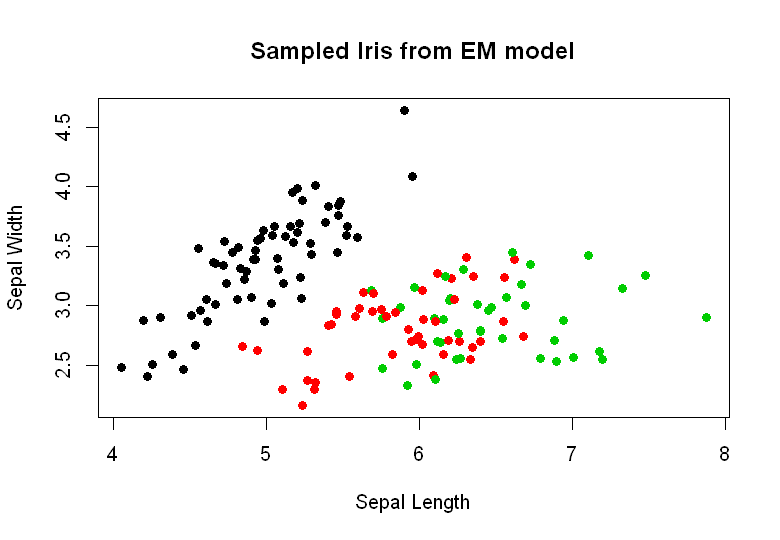

In [39]:
# show the sampled dataset
options(repr.plot.width = 6.5, repr.plot.height = 4.5)
plot(sampled_iris[, 1:2], col = sample_species, pch = 16,
xlab="Sepal Length", ylab='Sepal Width' ,main = "Sampled Iris from EM model")

## Bernoulli Mixture Models

Finally, we will apply a bernoilli mixture model to a subset of the MNIST dataset. We start by preparing the data.

In [51]:
data(digits)

In [52]:
mnist_labels <- digits[, 1]
mnist <- digits[, -1]

In [53]:
# function for plotting
plot_digit <- function(row){
    digit <- matrix(row, nrow=28, ncol=28)
    digit[digit > 0 ] <- 1
    image(digit, col=gray(255:0 / 255))
}

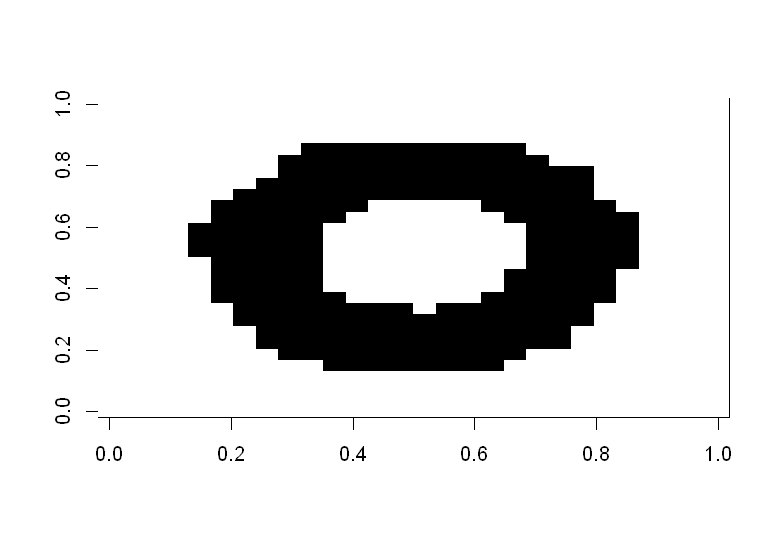

In [54]:
plot_digit(mnist[1,])

## Compute the binomial model using the Expectation Maximization Algorithm

In [55]:
new_digit <- mnist[3500, ] #test case for subsequent demonstration of prediction
mnist <- mnist[-3500,]

In [56]:
# EM for binomial mixture model
number_cluster <- 4
set.seed(2022)
binomial_em <- flexmix(as.matrix(mnist)~1, k = number_cluster, model=FLXMCmvbinary(), control=list(iter =100))

In [57]:
binomial_em


Call:
flexmix(formula = as.matrix(mnist) ~ 1, k = number_cluster, model = FLXMCmvbinary(), 
    control = list(iter = 100))

Cluster sizes:
   1    2    3    4 
3087 3371 2710 2831 

convergence after 57 iterations

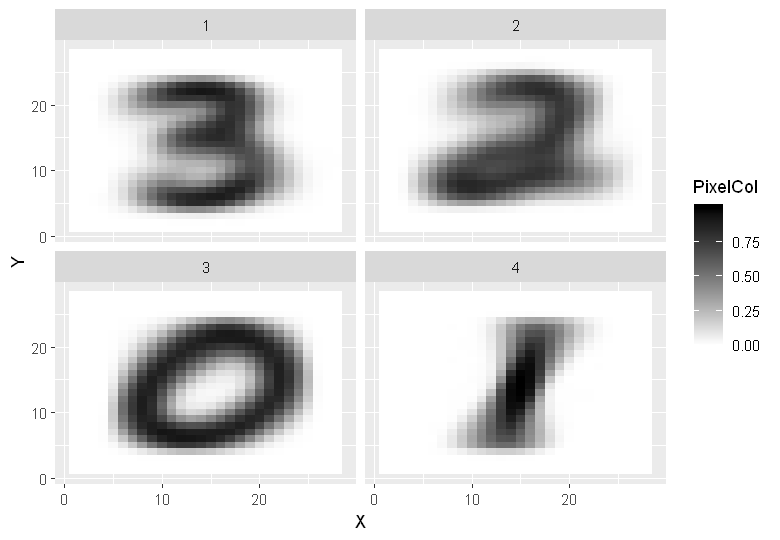

In [58]:
cluster_parameters <- parameters(binomial_em)
df <- data.frame( PixelCol = as.vector(cluster_parameters), Cluster = rep(1:number_cluster, each = 784),
X = rep(rep(1:28, 28),number_cluster), Y = rep(rep(28:1, each = 28), number_cluster))

# We show the cluster that the model estimated
ggplot(df, aes( x= X, y = Y, fill = PixelCol))+
geom_tile()+
scale_fill_gradient(low = "white", high = "black")+
facet_wrap(~ Cluster)

## Classify and Sample New Data

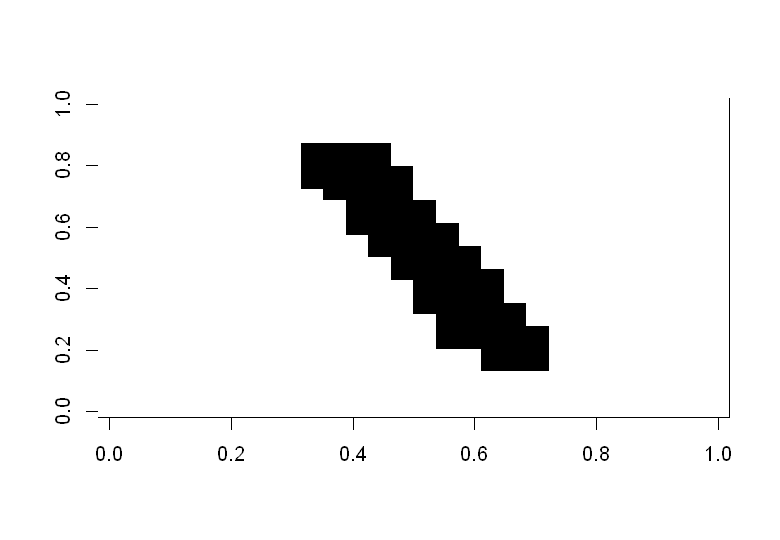

In [59]:
# now classify the new data
plot_digit(new_digit)

In [60]:
 # compute the posterior probabilities for each cluster
cluster_probabilities <- numeric(4)
for (j in 1:4) {
  cluster_probabilities[j] <- mean(prior(binomial_em)[j] * dbinom(new_digit, 784, parameters(binomial_em)[, j]))
}
which.max(cluster_probabilities / sum(cluster_probabilities)) 

[1] 4

We would assign the new datapoint to the fourth cluster which represents the number 1. Indeed, this is the correct cluster, however, this does not wor in general. Below, we calculate the accuracy for the estimated clusters that the binomial mixture model assigned the datapoints from mnist to.

In [61]:
estimated_cluster <- binomial_em@cluster
# relabeling
estimated_cluster[estimated_cluster == 3] <- 0
estimated_cluster[estimated_cluster == 1] <- 3
estimated_cluster[estimated_cluster == 4] <- 1

(ct <- table(mnist_labels[-3500], estimated_cluster))
sum(diag(ct)) / length(mnist_labels[-3500])

   estimated_cluster
       0    1    2    3
  0 2623    2  212  163
  1    0 2758  124  117
  2   33   26 2390  551
  3   54   45  645 2256

[1] 0.835653

Accuracy is ~83% which is not too bad. With the model at hand, we are also able to sample new observations from the clusters. Below, this is demonstrated by sampling from cluster three, hence a zero.

In [62]:
set.seed(2022)
sample_zero <- rbinom(784, 1, parameters(binomial_em)[,3])


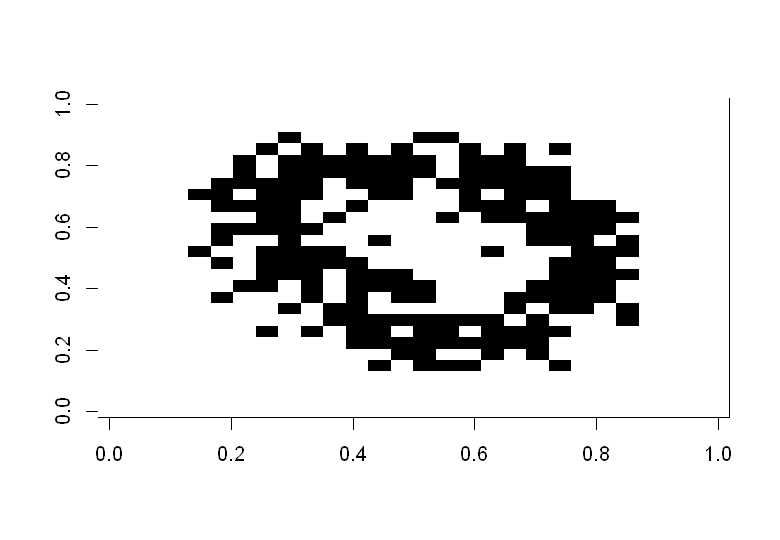

In [63]:
plot_digit(sample_zero)